https://github.com/neeyoo/Neuralnetwork_project_art_transfer

# nst_utils

In [ ]:
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import imageio
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf

In [ ]:
# !pip3 install --upgrade --force-reinstall tensorflow-gpu==1.15.0 

In [ ]:
tf .__version__

'1.15.0'

In [ ]:
class CONFIG:
    IMAGE_WIDTH = 800
    IMAGE_HEIGHT = 600
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

In [ ]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [ ]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1,CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

# Art generation

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
# from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

In [ ]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C,(n_H*n_W,n_C)))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)),[0,1])
    ### END CODE HERE ###
    
    return J_content


In [ ]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,A,transpose_b=True)
    ### END CODE HERE ###
    
    return GA

In [ ]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,(n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*n_C*n_C*n_H*n_H*n_W*n_W))*tf.reduce_sum(tf.square(tf.subtract(GS,GG)),[0,1])

    ### END CODE HERE ###
    
    return J_style_layer

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [ ]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [ ]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content+beta*J_style
    ### END CODE HERE ###
    
    return J

In [ ]:
#Change to input image with a format of RGB 800*600

def imagetransfer(path):
    png = Image.open(path)
    temp=imageio.imread(path)
    if temp.shape[2]==4:
        png.load() # required for png.split()
        transfered = Image.new("RGB", png.size, (255, 255, 255))
        transfered.paste(png, mask=png.split()[3]) # 3 is the alpha channel
        size = 800, 600
        transfered = transfered.resize(size, Image.ANTIALIAS)
        transfered.save(path[:-4]+str("_transfered.png"), 'PNG')
    else:
        size = 800, 600
        transfered = png.resize(size, Image.ANTIALIAS)
        transfered.save(path[:-4]+str("_transfered.png"), 'PNG')
    
    return None

In [ ]:
# from tensorflow.python.framework import ops

In [ ]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls /content/drive/MyDrive/

 20200912a_YL_ENAR_abstract.gdoc
'6.862 Share_Papers and Links.gdoc'
'A_Sunday_on_La Grande_Jatte.png'
 boston-charles-river-in-autumn-john-burk.jpg
 Boston-Public-Garden.jpg
 CBIS_DDSM.zip
'Colab Notebooks'/
 Desktop/
 Documents/
 flower.jpg
 freestyle.jpg
 freestyle_transfered.png
 fushihui2.jpg
 fushihui.jpg
 fushihui_transfered.png
 girl.jpg
 gold_gate.jpg
 grass.jpg
 grass_transfered.png
 harvard.jpg
 imagenet-vgg-verydeep-19.mat
 kulou.jpg
 kulou_transfered.png
 kusama.jpg
 kusama_transfered.png
 Liz_Andy.jpg
'Liz Andy _transfered.png'
 Liz_Andy_transfered.png
'Liz Andy Warhol THIS_0.jpg'
'Mediation software papers.gsheet'
 MIT.jpg
 MIT_transfered.png
 models/
 newbury.jpg
 norwood.png
 norwood_transfered.png
 Notability/
 output18065/
 peanutbutter.png
 peanutbutter_transfered.png
 Photos/
 picasso.jpg
 shout.jpg
 shout_transfered.png
 snow.jpg
 starry_night.jpg
 style.jpg
 style_transfered.png
'Summary of citations.gsheet'
 varnish.jpg
 varnish_transfered.png
 venis.jpg
 winter

## Load content and style images and transfer



In [ ]:
imagetransfer("/content/drive/MyDrive/MIT.jpg")
#im = Image.open("images/Content.png")

content_image = imageio.imread("/content/drive/MyDrive/MIT_transfered.png")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
imagetransfer("/content/drive/MyDrive/A_Sunday_on_La_Grande_Jatte.png")
style_image = imageio.imread("/content/drive/MyDrive/A_Sunday_on_La_Grande_Jatte_transfered.png")
style_image = reshape_and_normalize_image(style_image)

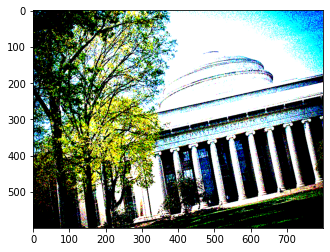

In [ ]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

## Load VGG19 model

In [ ]:
model = load_vgg_model("/content/drive/MyDrive/imagenet-vgg-verydeep-19.mat")

In [ ]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [ ]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [ ]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            imageio.imwrite("/content/drive/MyDrive/output18065/" + str(i) + ".png", generated_image[0,:,:,:])
    
    # save last generated image
    imageio.imwrite('/content/drive/MyDrive/output18065/generated_image.jpg', generated_image[0,:,:,:])
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 467749020.0
content cost = 7767.791
style cost = 11691784.0


Iteration 20 :
total cost = 60158870.0
content cost = 11584.76
style cost = 1501075.6


Iteration 40 :
total cost = 25698022.0
content cost = 12466.576
style cost = 639333.9


Iteration 60 :
total cost = 15102222.0
content cost = 12909.974
style cost = 374328.06


Iteration 80 :
total cost = 10640006.0
content cost = 13180.423
style cost = 262705.06


Iteration 100 :
total cost = 8256510.5
content cost = 13384.05
style cost = 203066.75


Iteration 120 :
total cost = 6749359.0
content cost = 13549.988
style cost = 165346.47


Iteration 140 :
total cost = 5699649.0
content cost = 13694.13
style cost = 139067.69


Iteration 160 :
total cost = 4919492.5
content cost = 13816.857
style cost = 119533.09


Iteration 180 :
total cost = 4313983.0
content cost = 13920.842
style cost = 104369.37


array([[[[  1.0895447 ,   0.54418147,  45.21137   ],
         [-27.412785  , -60.80089   , -31.33933   ],
         [-22.454195  , -51.06662   , -30.975029  ],
         ...,
         [-29.725601  , -14.8712435 ,  36.354618  ],
         [-26.121515  , -17.18761   ,  50.66539   ],
         [-28.936804  ,  10.831101  ,  70.41019   ]],

        [[  1.0213293 , -20.096256  ,   6.3220887 ],
         [-30.8161    , -38.584156  , -42.697014  ],
         [-27.987488  , -27.908823  , -31.991888  ],
         ...,
         [-21.584908  , -57.201855  , 119.1739    ],
         [-58.528812  , -44.978256  ,  85.71402   ],
         [-28.778486  ,  -3.81818   ,  61.443527  ]],

        [[-20.316488  , -18.047554  ,   0.5042757 ],
         [-26.434319  , -35.539864  , -20.445404  ],
         [-41.97611   , -24.175982  , -33.047153  ],
         ...,
         [-35.370144  ,   0.7039598 ,  55.954197  ],
         [-38.272186  , -44.15064   ,  82.22354   ],
         [-21.08209   ,  -3.9401443 ,  60.927345  ]],